Copyright 2021 Exa Research, LLC

# Fun with Angle Biases!

This workbook explores the issues around assuming that you can transform angle measurements from one coordinate frame representation to another while doing orbit determination. An issue that orbit analysts run into is that the antennas physical angle coordinate representation are different than the coordinate representation that is reported as the angle measurement. For example, an antenna using an X-Y mount should properly report X-Y angles as the measurements. But some systems will transform X-Y angles into the equivalent Az-El representation for ease of processing during the OD analysis, typically because the OD tools used don't have a native X-Y angle measurement model or the tracking data format doesn't support X-Y angles. This usually happens when you get access to an XY antenna that you weren't expecting to use and thus your systems and processes aren't quite ready to handle it. This can lead to trouble getting a good OD and interpreting your results. In this notebook I explore the affect of this transformation and how it can hurt you.

# Background

A ground antenna (or tracker in general) has a physical mount configuration used to point it at a resident space object (RSO). The mounting hardware lets the antenna pivot about two orthogonal angles, allowing it to point at any location in the sky. The most common of these mounts are Azimuth-Elevation (also known as Azimuth over Elevation), X-Y, or a polar mount.  The axes of rotation have angle encoders to measure the value of the angles the antenna is pointed at. These angles are often used as measurements (or observations) to feed an orbit determination (OD) process.

Mathematically there's a direct transformation from X-Y to Az-El and vice-versa, so on the surface this isn't an issue. But in practice the X-Y angles aren't perfect - they have biases introduced from the mechanics of the mount structure and errors in the encoders, along with environmental effects due to ionosphere and troposphere refraction. What I want to do is show the effect of a bias in one coordinate representation and how it manifests itself in a different coordinate representation.

To avoid reinventing the wheel I'll follow the coordinate frame definitions used by NASA's Jet Propulsion Laboratory (JPL) in their classic report [Formulation for Observed and Computed Values of Deep Space Network Data Types for Navigation](https://descanso.jpl.nasa.gov/monograph/series2/Descanso2_all.pdf) by Theodore Moyer, often referred to as "look it up in Moyer ...". This is volume 2 of the volumes published by JPL's Deep Space Communication and Navigation Systems (DESCANSO) [book series](https://descanso.jpl.nasa.gov/monograph/mono.html).

# Measurement Models

The angles are measured within a topocentric frame local to the antenna itself. Following the definitions from Moyer, Section 9.2, this is the North-East-Zenith (NEZ) frame where

 > The unit north N, east E, and zenith Z vectors originate at the tracking station S, which has an east longitude of λ. The unit vectors N and Z are in the tracking station's meridian plane, and E is normal to it. ... The zenith vector Z is normal to the reference ellipsoid for the Earth.

I've included a copy of Moyer's Figure 9.2 below for context.

<img src="images/Moyer_Fig_9-2_NEZ_Coordinate_System.png" alt="The North-East-Zenith Coordinate System" style="display:block; margin:auto"/>
<p style="text-align: center">
    <b>Moyer Figure 9-2. The North-East-Zenith Coordinate System</b>
</p>

Now looking at the station S itself, Moyer defines the Azimuth $\sigma$ and Elevation $\gamma$ angles 

<img src="images/Moyer_Fig_9-3_AzEl_Coordinates.png" alt="Azimuth-Elevation Coordinates" style="display:block; margin:auto"/>

<p style="text-align: center">
    <b>Moyer Figure 9-3. Azimuth and Elevation Angles</b>
</p>

and the XY angles are defined as

<img src="images/Moyer_Fig_9-4_XY_Coordinates.png" alt="X-Y Coordinates" style="display:block; margin:auto"/>
<p style="text-align: center">
    <b>Moyer Figure 9-4. X and Y Angles</b>
</p>

We can convert X-Y angles to a unit vector in NEZ Cartesian coordinates and then to Az-El coordinates. Note that the NEZ frame is NOT a right-handed frame (as most Cartesian coordinates are usually defined). From Moyer Eqs. 9-45 and 9-46 we have

$$
\begin{align}
N &= \sin{Y} \\
E &= \sin{X}\cos{Y} \\
Z &= \cos{X}\cos{Y}
\end{align}
$$

and from Moyer Eqs 9-42 to 9-44 we calculate azimuth and elevation (being sure to respect the quadrant of azimuth)

$$
\begin{align}
Az &= \arctan{\frac{E}{N}} \\
E
l &= \arcsin{Z}
\end{align}
$$

We can implement these as functions $N, E, Z = F(X, Y)$ and $Az, El = G(N, E, Z)$.

# Bias Models

Now that we have the ideal models sorted out, let's introduce the biases. We'll assume that the biases are constant additive offsets in the original coordinates (XY in our case). Pragmatically there's no physical reason for them to be constant, it's just a reasonable model in many cases. We can write

$$
\begin{align}
X &= X_{true} + \Delta X \\
Y &= Y_{true} + \Delta Y
\end{align}
$$

where $X$ and $Y$ are the observed angle values, $X_{true}$ and $Y_{true}$ are the true values, and the $\Delta$ terms are the biases. Writing the az-el models in a similar fashion we have

$$
\begin{align}
Az &= Az_{true} + \Delta Az \\
El &= El_{true} + \Delta El
\end{align}
$$

When there are no X-Y angle biases there is a nice clean mapping from the *True* values of X, Y to the *True* values of N, E, Z, and then to the *True* values of Az, El using

$$ Az_{true}, El_{true} = G(F(X_{true}, Y_{true}))$$

The observed values are computed using

$$ Az, El = G(F(X, Y))$$

and we can solve for the azimuth and elevation biases

$$
\begin{align}
\Delta Az &= Az - Az_{true} \\
\Delta El &= El - El_{true}
\end{align}
$$

Ideally these biases would be constant, but they aren't because of all the non-linear trigonometry that's going on. Rather than analytically deriving the solution for these, we'll just run a bunch of numerical test cases and plot some results. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

%matplotlib inline
plt.rcParams.update({'font.family':'Gudea'})

In [2]:
# All angles assumes to be in radians. The NEZ components
# are assumed to represent a unit vector.

# from Moyer, Eq. 9-45 and 9-46. 

# X and Y can be arrays. If they are both rows of shape (N,) we'll
# return an array of shape (N, 3). If X is an array of shape (N, 1) 
# with N rows and 1 column, and Y is an array of shape (M, ) with 
# 1 row of M column, then we will return an array of shape (N, M, 3).
    
def xy_to_nez(x, y):

    n = np.sin(y)
    e = np.sin(x) * np.cos(y)
    z = np.cos(x) * np.cos(y)

    return np.stack(np.broadcast_arrays(n, e, z), -1)

def nez_to_xy(nez):
    
    # Get the n values from nez. Since nez is a 
    # matrix of shape (..., 3), the n values are in the
    # 0 position of the last axis in nez. That's why
    # we use nez[..., 0]. The resulting
    # matrix or array has duplicate row values, so 
    # we only need to use the first row, thus the final
    # [0] elements are grabbed. When nez is shape (N, M, 3)
    # the resulting y is shape (M,).
    
    n = nez[..., 0]
    e = nez[..., 1]
    z = nez[..., 2]
    
    # You can't naively code this as x = np.arcsin(e / np.cos(y)) like
    # Moyer suggests because the denominator can go to zero and blow 
    # the whole thing up ...
    
    x = np.arctan2(e, z)    
    y = np.arcsin(n)
     
    return x, y

# from Moyer, Eq. 9-42 to 9-44

def azel_to_nez(az, el):
   
    # Use the same shape management approach from the
    # XY angle conversions above.
    
    n = np.cos(el) * np.cos(az)    
    e = np.cos(el) * np.sin(az)
    z = np.sin(el)
        
    return np.stack(np.broadcast_arrays(n, e, z), -1)


def nez_to_azel(nez):

    n = nez[..., 0]
    e = nez[..., 1]
    z = nez[..., 2]
    
    el = np.arcsin(z)
    az = np.arctan2(e, n)

    # Force positive azimuth numbers. Make sure it works
    # with NumPy arrays ...
    
    if np.isscalar(az):
        if az < 0: az += 2 * np.pi
    else:
        az_is_neg = az < 0
        az[az_is_neg] = az[az_is_neg] + 2 * np.pi
    
    return az, el

In [3]:
# dump out some test cases

for x, y in [(0, 0), (0, 90), (0, -90), 
             (90, 0), (90, 90), (90, -90), 
             (-90, 0), (-90, 90), (-90, -90),
             (45, 0), (45, 90), (-45, 0), (-45, -90)]:

    # Compute NEZ values
    x_rad, y_rad = np.radians((x, y))
    nez = xy_to_nez(x_rad, y_rad)
    
    # Convert back to XY and verify the same answer
    x_test, y_test = nez_to_xy(nez)
    assert(np.isclose(x_test, x_rad))
    assert(np.isclose(y_test, y_rad))   
    
    # Compute Az-El values
    az_rad, el_rad = nez_to_azel(nez)
    az, el = np.degrees((az_rad, el_rad))
    
    # Convert back to NEZ and verify the same answer
    nez_test = azel_to_nez(az_rad, el_rad)
    assert(np.isclose(nez_test, nez).all())
    
    # Dump out the sample cases for a visual sanity test
    print(f'xy = ({x:3}, {y:3}) deg --->  nez ({nez[0]:6.1f}, {nez[1]:6.1f}, {nez[2]:6.1f})  --->  az, el ({az:6.1f}, {el:6.1f}) deg')

xy = (  0,   0) deg --->  nez (   0.0,    0.0,    1.0)  --->  az, el (   0.0,   90.0) deg
xy = (  0,  90) deg --->  nez (   1.0,    0.0,    0.0)  --->  az, el (   0.0,    0.0) deg
xy = (  0, -90) deg --->  nez (  -1.0,    0.0,    0.0)  --->  az, el ( 180.0,    0.0) deg
xy = ( 90,   0) deg --->  nez (   0.0,    1.0,    0.0)  --->  az, el (  90.0,    0.0) deg
xy = ( 90,  90) deg --->  nez (   1.0,    0.0,    0.0)  --->  az, el (   0.0,    0.0) deg
xy = ( 90, -90) deg --->  nez (  -1.0,    0.0,    0.0)  --->  az, el ( 180.0,    0.0) deg
xy = (-90,   0) deg --->  nez (   0.0,   -1.0,    0.0)  --->  az, el ( 270.0,    0.0) deg
xy = (-90,  90) deg --->  nez (   1.0,   -0.0,    0.0)  --->  az, el ( 360.0,    0.0) deg
xy = (-90, -90) deg --->  nez (  -1.0,   -0.0,    0.0)  --->  az, el ( 180.0,    0.0) deg
xy = ( 45,   0) deg --->  nez (   0.0,    0.7,    0.7)  --->  az, el (  90.0,   45.0) deg
xy = ( 45,  90) deg --->  nez (   1.0,    0.0,    0.0)  --->  az, el (   0.0,    0.0) deg
xy = (-45,

# Bias Effects

Now that we have the basic coordinate models implemented, let's evaluate the effect of the XY bias on a single "true" az/el vector. And as always, watch your units! 

We have to be careful in computing our azimuth errors because azimuth is circular - it rolls over at 360. So we have to be smart about calculating the signed angle difference as the angles could pass through the 360->0 transition. There's also the issue of the singularity at elevations near $\pm$90 deg where the slightest change in the nez vector can swing the azimuth wildly, even though the net absolute angle error is relatively small. An approach that is often used in orbit determination tools to is to weight the azimuth difference by the cosine of the elevation angle. 

In [4]:
def angle_delta_deg(a, b):
    
    # Implements the signed angle difference of a-b, 
    # keeping in mind that angles are circular
    
    a_rad = np.radians(a)
    b_rad = np.radians(b)
    
    theta_rad = np.arctan2(np.sin(a_rad - b_rad), np.cos(a_rad - b_rad))    
    theta_deg = np.degrees(theta_rad)
    return theta_deg

def delta_azel_with_xy_bias(az_deg, el_deg, x_bias, y_bias):
    
    # Take the true az/el angles
    
    az_rad = np.radians(az_deg)
    el_rad = np.radians(el_deg)

    # Map them to the true X/Y angles

    nez_in = azel_to_nez(az_rad, el_rad)
    x_rad, y_rad = nez_to_xy(nez_in)
    
    # Apply the X/Y biases
    
    x_rad += np.radians(x_bias)
    y_rad += np.radians(y_bias)

    # Map this back to the "measured" az/el angles
    
    nez_out = xy_to_nez(x_rad, y_rad) 
    az_meas_rad, el_meas_rad = nez_to_azel(nez_out)
    az_meas_deg = np.degrees(az_meas_rad)
    el_meas_deg = np.degrees(el_meas_rad)

    # Compute the "delta" values
    
    az_delta = angle_delta_deg(az_meas_deg, az_deg)
    el_delta = el_meas_deg - el_deg
    
    # Compute the absolute angle error. In most cases we can
    # just call np.inner() to compute the dot product. 
    # But this doesn't work when the input az/el arrays are both 
    # multi-dimensional (N, M, 3) arrays. Plus einsum() is much faster
    # than doing something like np.inner(x, y).diagonal() if 
    # the array sizes start to get larger
    
    if nez_in.ndim >=2:
        inner_product = np.einsum('...ij,...ij->...i', nez_in, nez_out)
    else:
        inner_product = np.inner(nez_in, nez_out)

    angle_delta = np.degrees(np.arccos(inner_product))
    
    # Compute the weighted azimuth error
    
    weighted_az_delta = az_delta * np.cos(el_rad)
    
    return az_delta, el_delta, angle_delta, weighted_az_delta

## Test a single point

We'll perturb a single az/el point and see how bad the result is. Let's start with a X bias of 0.1 degrees and measure the impact at an az/el of 0, 20 degrees. 

In [5]:
x_bias, y_bias = 0.1, 0

az_delta, el_delta, angle_delta, weighted_az_delta = delta_azel_with_xy_bias(0, 20, x_bias, y_bias)

print(f'{         az_delta =:7.3f} deg\n         {el_delta =:7.3f} deg')
print(f'      {angle_delta =:7.3f} deg')
print(f'{weighted_az_delta =:7.3f} deg')

         az_delta =  0.036 deg
         el_delta = -0.000 deg
      angle_delta =  0.034 deg
weighted_az_delta =  0.034 deg


That's not too bad - the X bias shows up primarily in the azimuth. This is not surprising, since the X angle is measured in the East West direction and we are evaluating the error as measured at an azimuth of 0. And there's little difference between the azimuth delta and the weighted azimuth delta. Now let's repeat it at a different az/el of 90, 20 degrees.


In [6]:
az_delta, el_delta, angle_delta, weighted_az_delta = delta_azel_with_xy_bias(90, 20, x_bias, y_bias)

print(f'{         az_delta =:7.3f} deg\n         {el_delta =:7.3f} deg')
print(f'      {angle_delta =:7.3f} deg')
print(f'{weighted_az_delta =:7.3f} deg')

         az_delta =  0.000 deg
         el_delta = -0.100 deg
      angle_delta =  0.100 deg
weighted_az_delta =  0.000 deg


We see the error showing up all in elevation, becasue our azimuth of 90 degrees puts the X bias directly in the elevation direction. Now let's look near zenith at an az/el of 45, 88 where we start to experience the azimuth singularity.

In [7]:
az_delta, el_delta, angle_delta, weighted_az_delta = delta_azel_with_xy_bias(45, 88, x_bias, y_bias)

print(f'{         az_delta =:7.3f} deg\n         {el_delta =:7.3f} deg')
print(f'      {angle_delta =:7.3f} deg')
print(f'{weighted_az_delta =:7.3f} deg')

         az_delta =  1.955 deg
         el_delta = -0.072 deg
      angle_delta =  0.100 deg
weighted_az_delta =  0.068 deg


We see the azimuth delta is an order of magnitude larger the the X angle bias we introduced.

## Evaluate over a range of azimuths

Let's do the same thing, but over a range of azimuth values and keeping elevation constant at 20 degrees. The errors both exhibit a sinusoidal pattern.

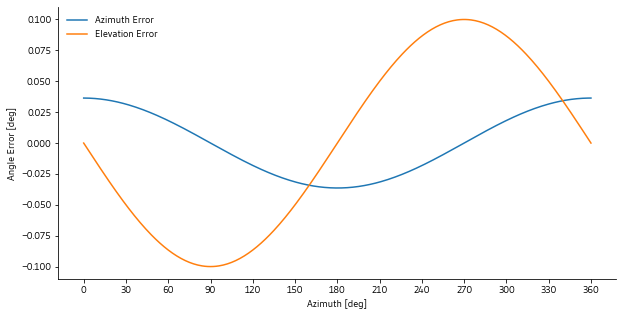

In [8]:
az_deg = np.arange(361)
el_deg = 20

az_delta, el_delta, angle_delta, weighted_az_delta = delta_azel_with_xy_bias(az_deg, el_deg, x_bias, y_bias)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(az_deg, az_delta, label='Azimuth Error')
ax.plot(az_deg, el_delta, label='Elevation Error')

ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Angle Error [deg]')
ax.set_xticks(range(0, 390, 30))
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False);

But when we move up to a high elevation of 88 degrees we see the azimuth error really starts to increase because we are approaching the singularity at zenith. At 90 degrees elevation the azimuth error becomes as large as 180 degrees as we "flip over the pole". This is why the weighted azimuth error becomes more useful metric, as we can see in the graph below.

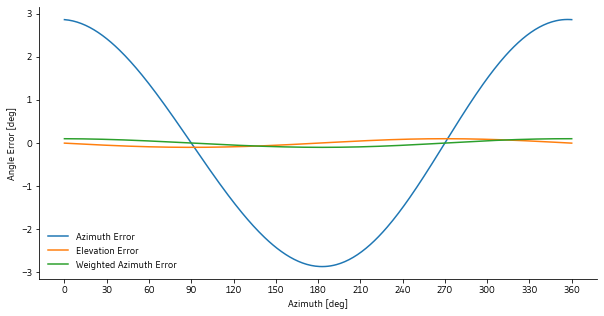

In [9]:
az_deg = np.arange(361)
el_deg = 88

az_delta, el_delta, angle_delta, weighted_az_delta = delta_azel_with_xy_bias(az_deg, el_deg, x_bias, y_bias)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(az_deg, az_delta, label='Azimuth Error')
ax.plot(az_deg, el_delta, label='Elevation Error')
ax.plot(az_deg, weighted_az_delta, label='Weighted Azimuth Error')

ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Angle Error [deg]')
ax.set_xticks(range(0, 390, 30))
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False);

## Evaluate over all azimuth and elevation values

Now let's create some plots showing the results of the angle biases. We'll use an approach from the computer graphics community where we'll generate samples (e.g. "pixels") of our true az, el values, calculate the corresponding true XY values, add the XY biases, then convert back to az, el and measure the difference. This will allow us to produce a nicely sampled 2D plot in az/el space. If we had generated a nice grid in XY space the sampling in az/el space would not be nice and evenly distributed, making the plots look a bit wonky.

In [10]:
def plot_angle_error(x_bias, y_bias):


    # Create a range of "true" az/el angles
    az_deg = np.arange(361)
    el_deg = np.arange(91)

    # Compute the corresponding "true" X/Y angles by converting to NEZ
    # and then to XY.

    azv, elv = np.meshgrid(az_deg, el_deg)

    az_delta, el_delta, angle_delta, weighted_az_delta = delta_azel_with_xy_bias(azv, elv, x_bias, y_bias)
    
    # Let's plot the errors in azimuth and elevation

    fig, axes = plt.subplots(2, 1, figsize=(10,15), subplot_kw={'projection':'polar'})    

    # Axes common stuff
    for ax in axes:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location("N")
        ax.set_rlabel_position(290)
        ax.set_rticks(np.arange(0, 115, 15))

        ax.annotate('Elevation Angle', xy=(np.radians(290), 0),
                    ha='right', textcoords='offset points', xytext=(-10, 5))

        # reverse the R axis so that 90 deg elevation is in the middle.
        ax.set_rlim(bottom=90, top=0)   

    cmap = 'Spectral'
    error_levels = np.linspace(-0.5, 0.5, 21, endpoint=True)

    # Azimuth error
    cs0 = axes[0].contourf(np.radians(az_deg), el_deg, az_delta, levels=error_levels, extend='both', cmap=cmap)
    axes[0].set_title('Azimuth Error')
    
    # Elevation error
    cs1 = axes[1].contourf(np.radians(az_deg), el_deg, el_delta, levels=error_levels, extend='both', cmap=cmap)
    axes[1].set_title('Elevation Error')

    # Add the color bar 
    cb = fig.colorbar(cs0, ax=axes, shrink=0.8, aspect=30)
    cb.set_label('Error [deg]')    

    fig.suptitle(f'Az/El Biases from X/Y Bias = {x_bias:.1f}, {y_bias:.1f} [deg]', fontsize=16)

First, let's start with the X bias of 0.1 degrees.

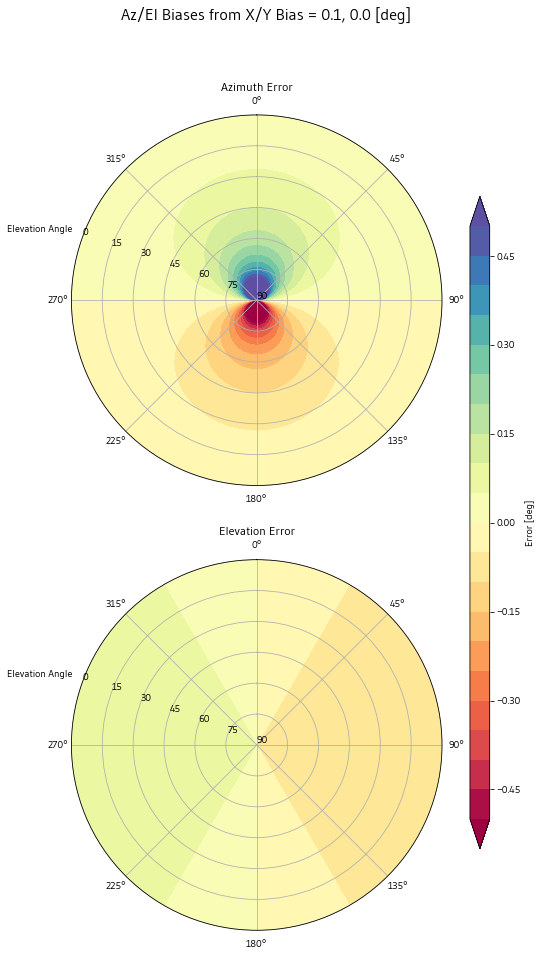

In [11]:
plot_angle_error(0.1, 0)

At high elevation angles the azimuth errors fall apart completely as we saw earlier, so to avoid making the error scale unreadable I've clamped it to a range of [-0.5, 0.5] degrees. The effect on elevation is not as dramatic, but still there. The main take away from this analysis is that the biases in the azimuth and elevation angle coordinates is very geometry dependent. A tracking pass that passes through one of the "lobes" in the azimuth plot will experience significant swings in the azimuth bias. If you are solving for a single constant bias you won't have good results. Let's do a few more test cases for good measure.

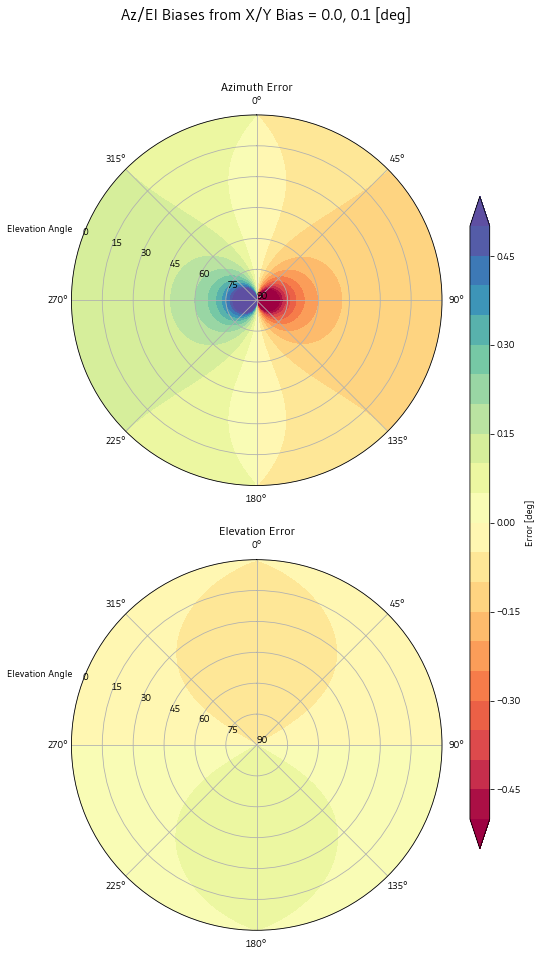

In [12]:
plot_angle_error(0, 0.1)

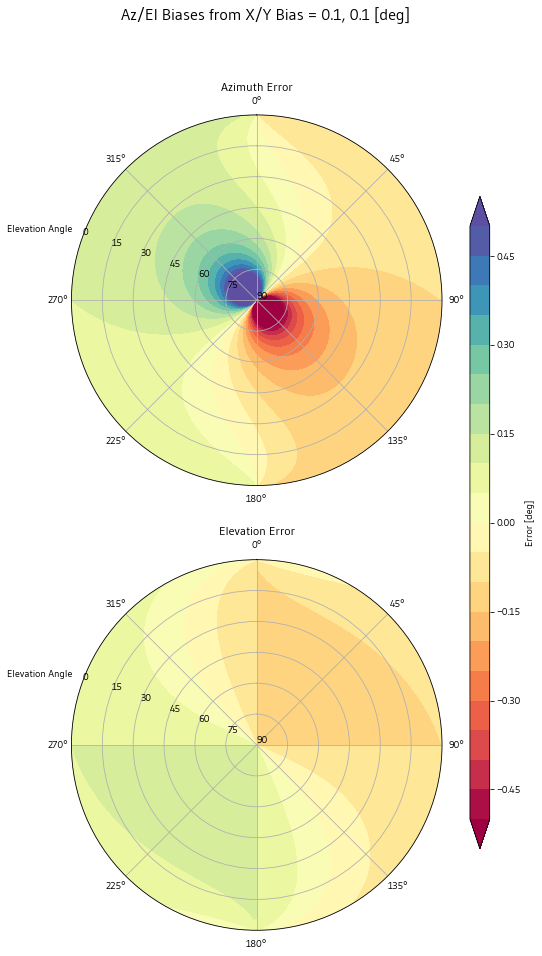

In [13]:
plot_angle_error(0.1, 0.1)
plt.savefig('az_el_bias.png', facecolor='white', dpi=600, bbox_inches='tight')

And one last plot with some pretty large biases introduced - these are typically much larger than any system should have, but it makes for a pretty plot ...

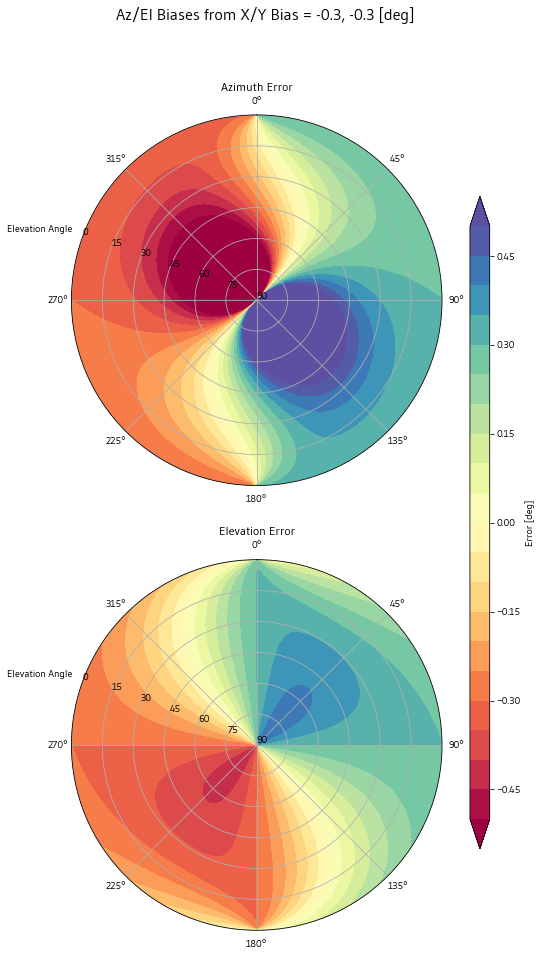

In [14]:
plot_angle_error(-0.3, -0.3)

# Final Thoughts

This issue of sensors operating in one set of coordinates but reporting in another occurs more often than people think. For example, a typical phased array radar like the ones used in the US Space Surveillance Network (SSN) publish az, el, range measurements, but the radar actually measures U, V, range where U and V are angles relative to the face of the antenna. If your sensor provider offers to "help" you by giving you azimuth and elevation when the sensor doesn't really operate this way then you should try get the "raw" measurements. At least you'll be eyes wide open about the types of results you might see. 